In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torchvision
from torchvision import models, transforms, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Hyper-Parâmetros

In [3]:
bs=1 
lr=0.0005 
beta1=0.5
beta2=0.999
NUM_EPOCHS = 100
ngpu = 1
L1_lambda = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Importe do DataLoader e o carregamento dele em Batches

In [21]:
data_dir = "maps-ex"

data_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.CenterCrop((256, 512)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset_train = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=data_transform)
dataset_val = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=data_transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=bs, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=24, shuffle=True, num_workers=0)

# Definição da função para mostrar a imagem

In [5]:
def show_image(img, title="No title", figsize=(5,5)):
    img = img.numpy().transpose(1,2,0)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    img = img * std + mean
    np.clip(img, 0, 1)
    
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.title(title)

In [6]:
images,_ = next(iter(dataloader_train))

sample_sat = images[0][:,:,:256]
sample_map = images[0][:,:,256:]

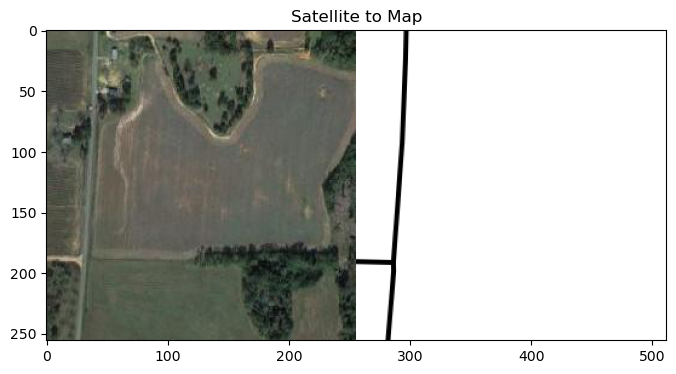

In [22]:
show_image(images[0], title="Satellite to Map", figsize=(8,8))

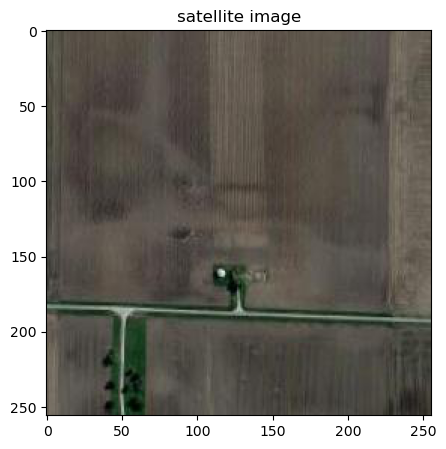

In [23]:
show_image(img = sample_sat, title = "satellite image", figsize=(5,5))

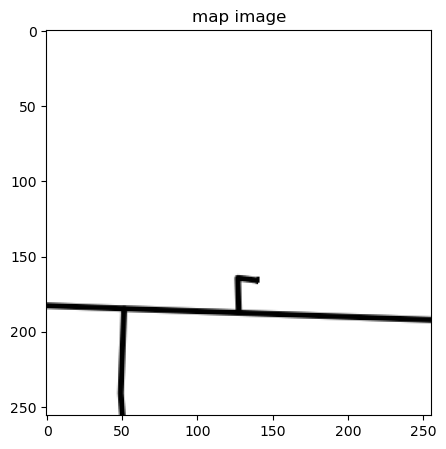

In [24]:
show_image(img = sample_map, title = "map image", figsize=(5, 5))

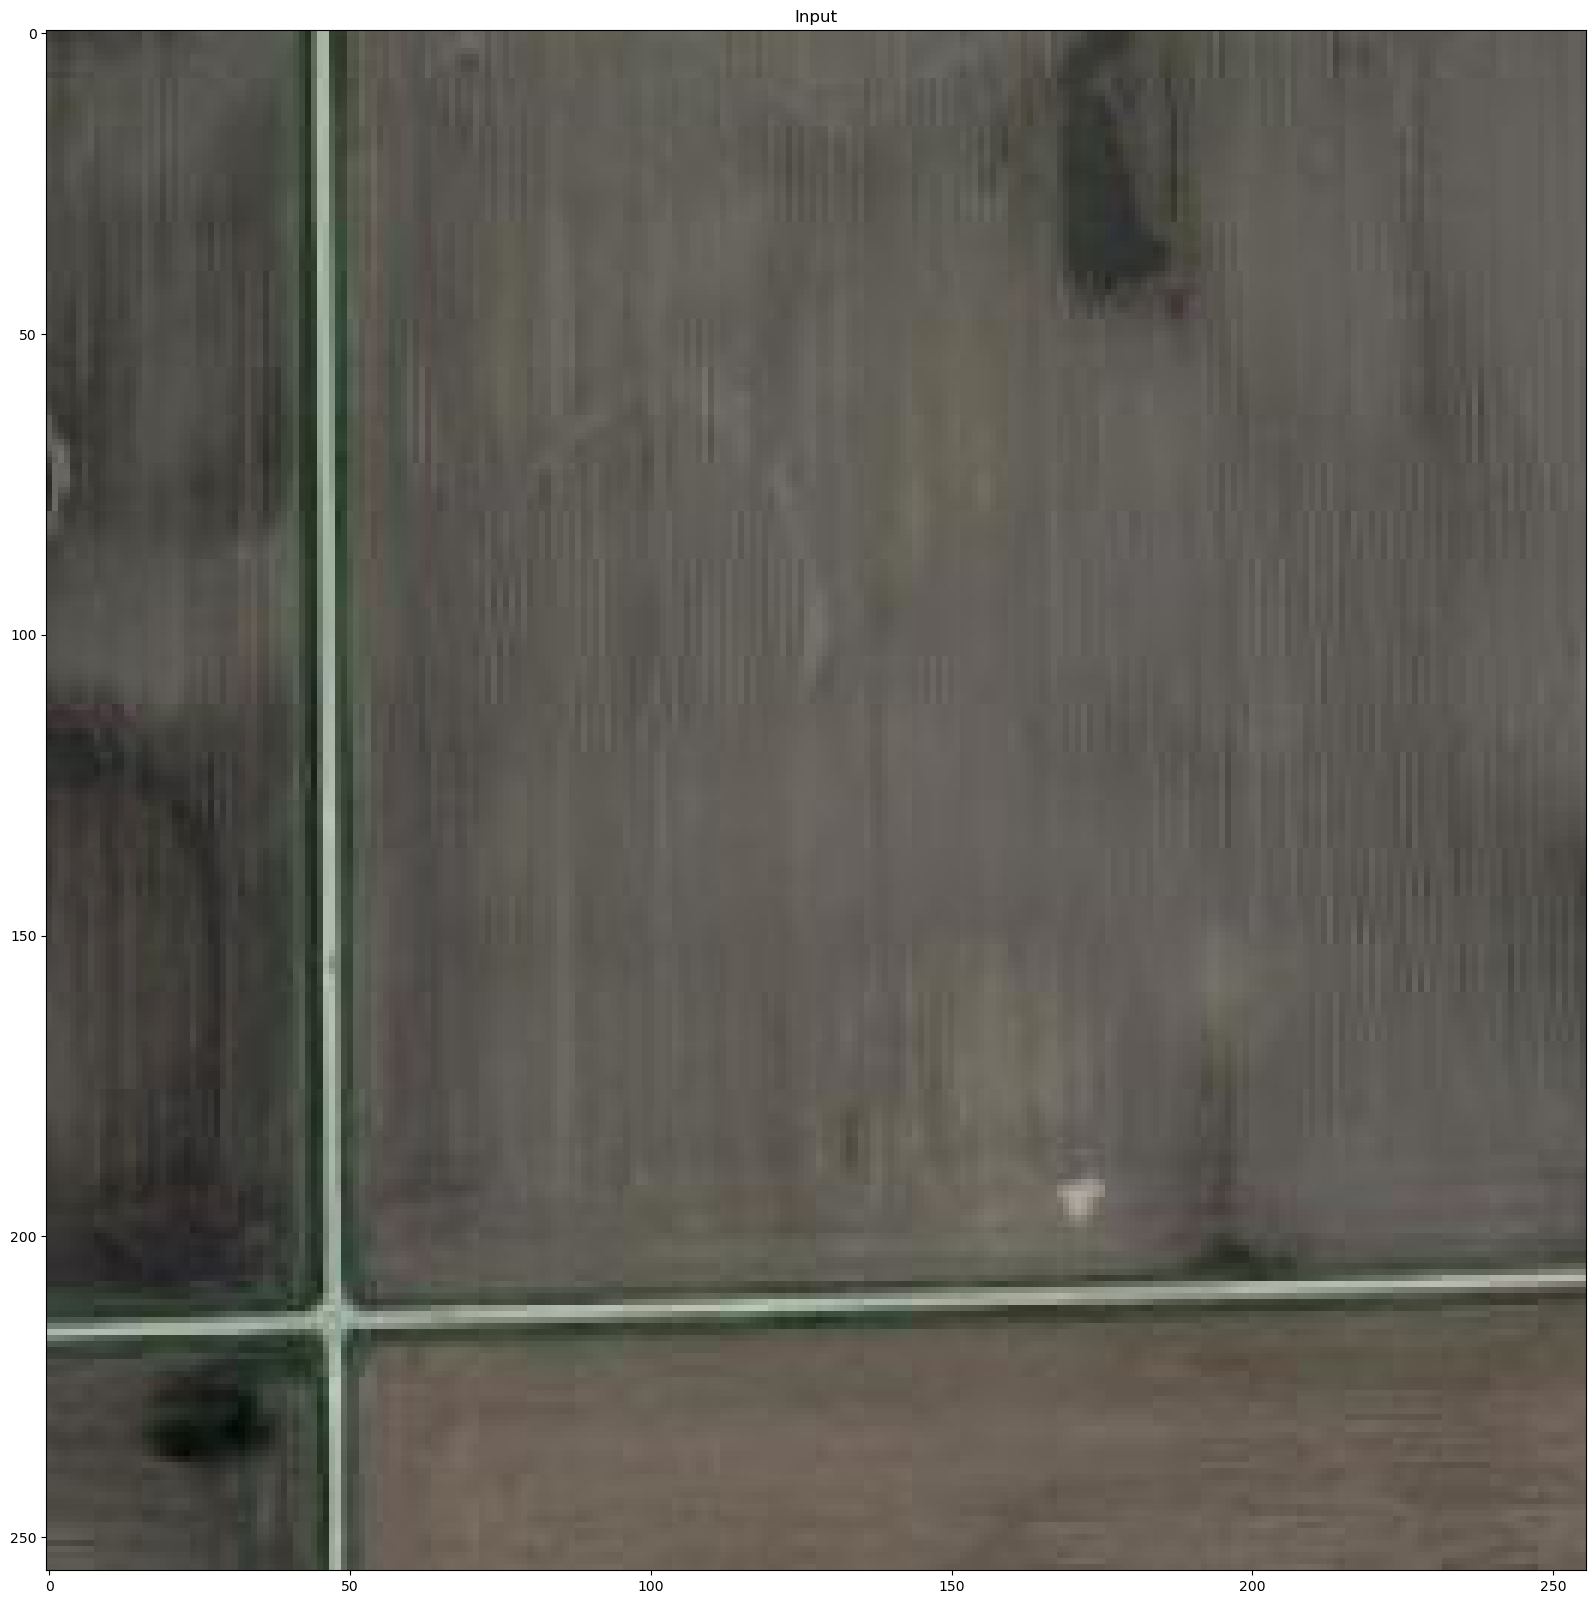

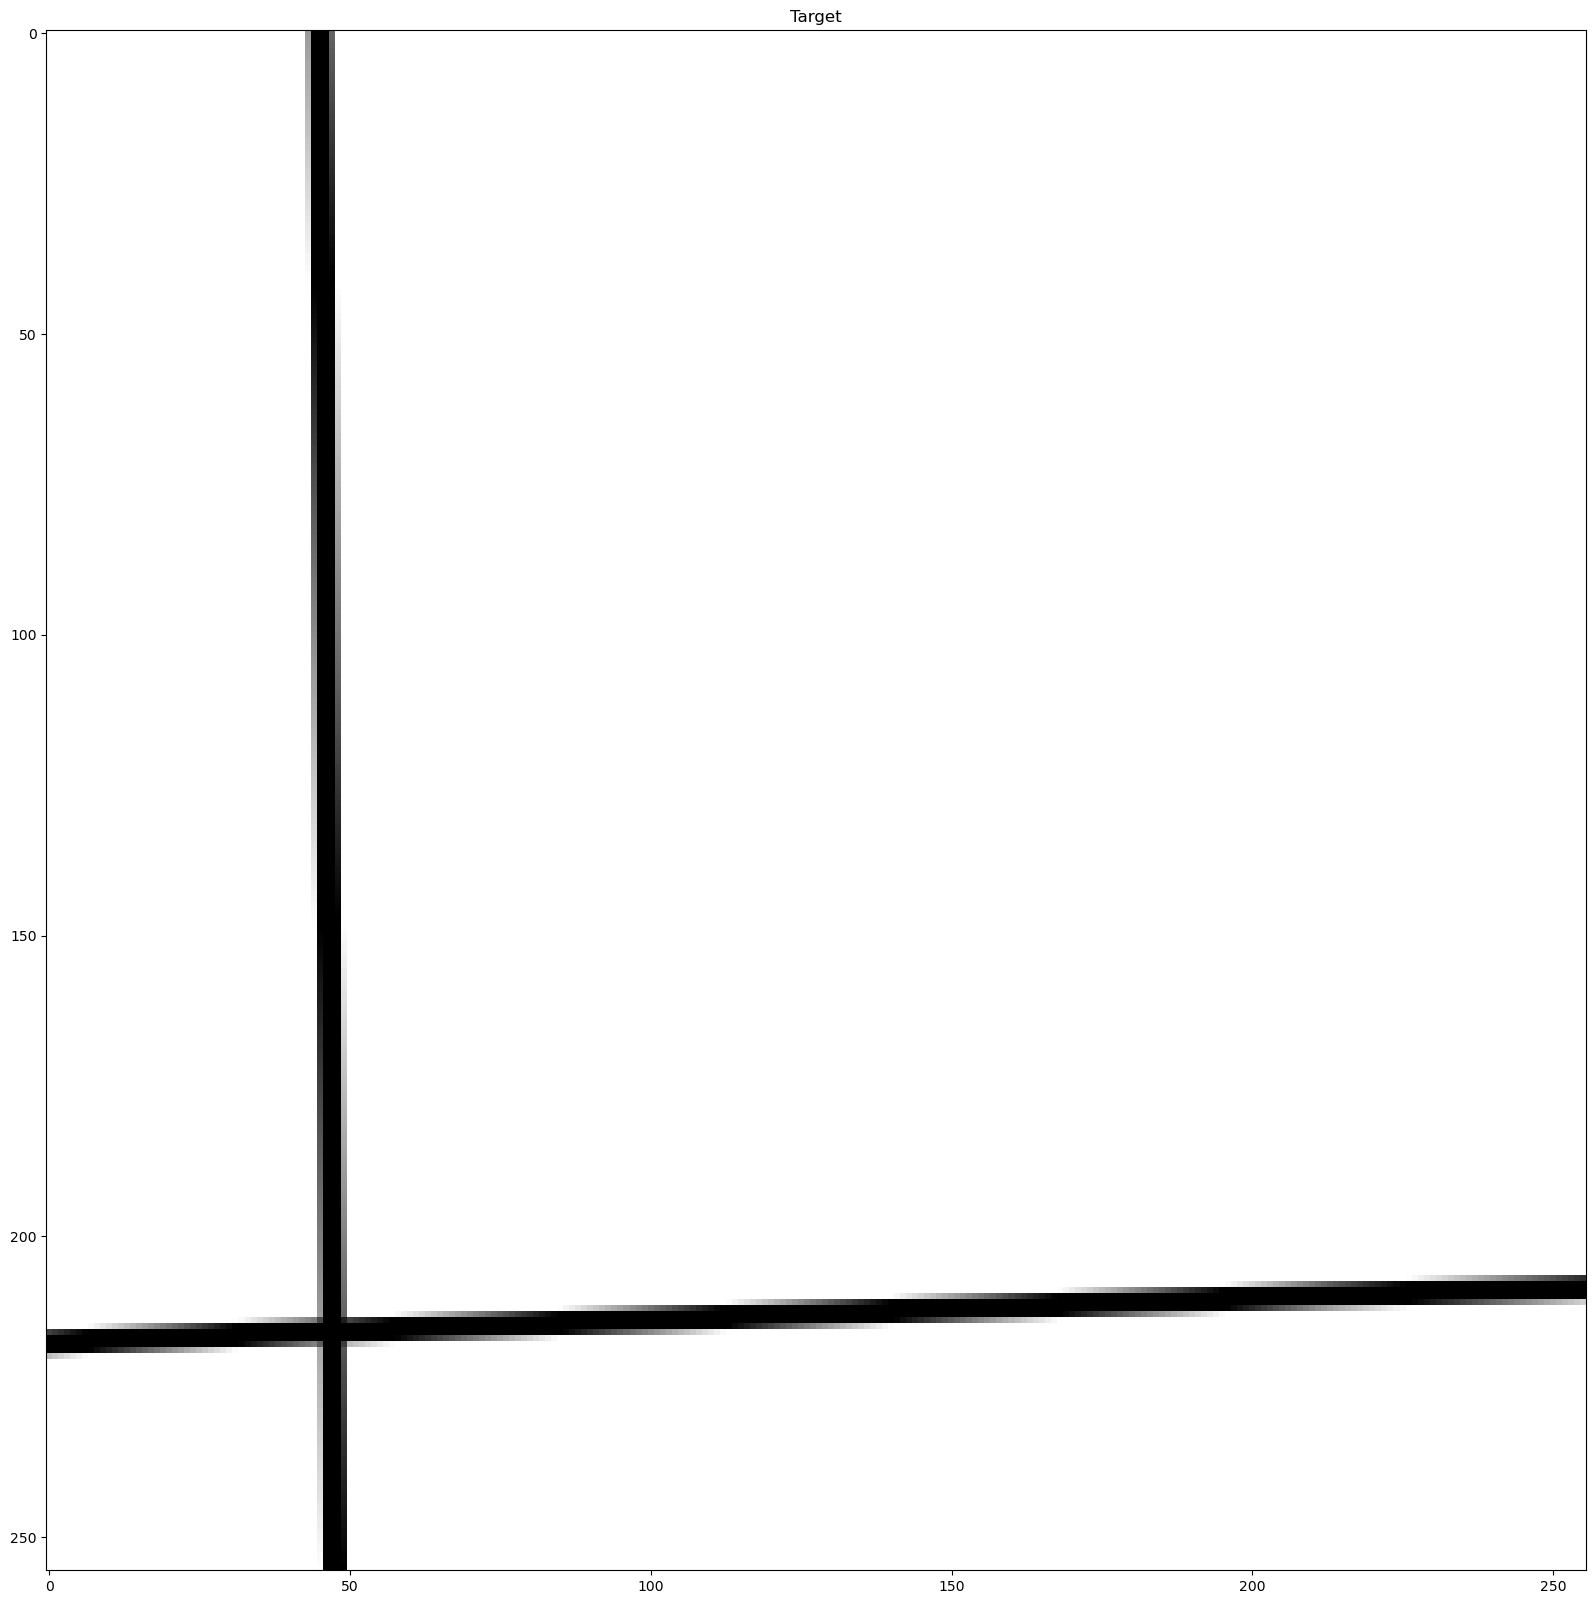

In [25]:
images,_ = next(iter(dataloader_train))
x = torchvision.utils.make_grid(images[:,:,:,:256], padding=10)
y = torchvision.utils.make_grid(images[:,:1,:,256:], padding=10)

# [? ; C ; H ; W]
# [? ; Channel ; Height ; Width ]

show_image(x, title="Input", figsize=(20,20))
show_image(y, title="Target", figsize=(20,20))

# Função para inicializar os pesos do modelo

In [11]:
def weights_init(m):
    name = m.__class__.__name__
    
    if(name.find("Conv") > -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02) # ~N(mean=0.0, std=0.02)
    elif(name.find("BatchNorm") > -1):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

# Definição da arquitetura do Gerador

In [12]:
"""
    The Generator is a U-Net 256 with skip connections between Encoder and Decoder
"""

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        """
        ===== Encoder ======
        
        * Encoder has the following architecture:
        0) Inp3 
        1) C64 
        2) Leaky, C128, Norm 
        3) Leaky, C256, Norm 
        4) Leaky, C512, Norm 
        5) Leaky, C512, Norm 
        6) Leaky, C512, Norm 
        7) Leaky, C512
        
        * The structure of 1 encoder block is:
        1) LeakyReLU(prev layer)
        2) Conv2D
        3) BatchNorm
        
        Where Conv2D has kernel_size-4, stride=2, padding=1 for all layers
        """
        self.encoder1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
        
        self.encoder2 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )
        
        self.encoder3 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
        )
        
        self.encoder4 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )
        
        self.encoder5 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )
        
        self.encoder6 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )
        
        self.encoder7 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False)
        )
        
        """
        ===== Decoder =====
        * Decoder has the following architecture:
        1) ReLU(from latent space), DC512, Norm, Drop 0.5 - Residual
        2) ReLU, DC512, Norm, Drop 0.5, Residual
        3) ReLU, DC512, Norm, Drop 0.5, Residual
        4) ReLU, DC256, Norm, Residual
        5) ReLU, DC128, Norm, Residual
        6) ReLU, DC64, Norm, Residual
        7) ReLU, DC3, Tanh()
        
        * Note: only apply Dropout in the first 3 Decoder layers
        
        * The structure of each Decoder block is:
        1) ReLU(from prev layer)
        2) ConvTranspose2D
        3) BatchNorm
        4) Dropout
        5) Skip connection
        
        Where ConvTranpose2D has kernel_size=4, stride=2, padding=1
        """
        self.decoder1 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )
        # skip connection in forward()
        
        self.decoder2 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )
        # skip connection in forward()
        
        self.decoder3 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )
        # skip connection in forward()
        
        self.decoder4 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512*2, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            #nn.Dropout(0.5)
        )
        
        self.decoder5 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=256*2, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            #nn.Dropout(0.5)
        )
        
        self.decoder6 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128*2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            #nn.Dropout(0.5)
        )
        
        self.decoder7 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64*2, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        
        latent_space = self.encoder7(e6)
        
        d1 = torch.cat([self.decoder1(latent_space), e6], dim=1)
        d2 = torch.cat([self.decoder2(d1), e5], dim=1)
        d3 = torch.cat([self.decoder3(d2), e4], dim=1)
        d4 = torch.cat([self.decoder4(d3), e3], dim=1)
        d5 = torch.cat([self.decoder5(d4), e2], dim=1)
        d6 = torch.cat([self.decoder6(d5), e1], dim=1)
        
        out = self.decoder7(d6)
        
        return out

# Inicialização do Gerador

In [13]:
model_G = Generator(ngpu=1)

if(device == "cuda" and ngpu > 1):
    model_G = nn.DataParallel(model_G, list(range(ngpu)))
    
model_G.apply(weights_init)
model_G.to(device)

Generator(
  (encoder1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (encoder2): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder3): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder4): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder5): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(512, 512, kernel_s

# Definição da arquitetura do Discriminador

In [14]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        self.structure = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.structure(x)

# Inicialização do Discriminador

In [15]:
model_D = Discriminator(ngpu=1)

if(device == "cuda" and ngpu>1):
    model_D = torch.DataParallel(model_D, list(rang(ngpu)))
    
model_D.apply(weights_init)
model_D.to(device)

Discriminator(
  (structure): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Carregamento da rede salva

In [17]:
model_G = torch.load("./sat2mapGen_v1.3.pth")
model_D = torch.load("./sat2mapDisc_v1.3.pth")

# Inicialização dos otimizadores e treinamento da rede

In [18]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(model_D.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(model_G.parameters(), lr=lr, betas=(beta1, beta2))


model_D.to(device)
model_G.to(device)
print()

In [19]:
inp = images[:,:,:,:256]
target = images[:,:1,:,256:]

print(inp.shape)
print(target.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


In [ ]:
for epoch in range(NUM_EPOCHS+1):
    print(f"Training epoch {epoch+1}")
    for images,_ in iter(dataloader_train):
        # ========= Train Discriminator ===========
        # Train on real data
        # Maximize log(D(x,y)) <- maximize D(x,y)
        model_D.zero_grad()
        
        inputs = images[:,:,:,:256].to(device) # input image data
        targets = images[:,:1,:,256:].to(device) # real targets data
        
        real_data = torch.cat([inputs, targets], dim=1).to(device)
        outputs = model_D(real_data) # label "real" data
        labels = torch.ones(size = outputs.shape, dtype=torch.float, device=device)
        
        lossD_real = 0.5 * criterion(outputs, labels) # divide the objective by 2 -> slow down D
        lossD_real.backward()
        
        # Train on fake data
        # Maximize log(1-D(x,G(x))) <- minimize D(x,G(x))
        gens = model_G(inputs).detach()
         
        fake_data = torch.cat([inputs, gens], dim=1) # generated image data
        outputs = model_D(fake_data)
        labels = torch.zeros(size = outputs.shape, dtype=torch.float, device=device) # label "fake" data
        
        lossD_fake = 0.5 * criterion(outputs, labels) # divide the objective by 2 -> slow down D
        lossD_fake.backward()
        
        optimizerD.step()
        
        # ========= Train Generator x2 times ============
        # maximize log(D(x, G(x)))
        for i in range(2):
            model_G.zero_grad()
            
            gens = model_G(inputs)
            
            gen_data = torch.cat([inputs, gens], dim=1) # concatenated generated data
            outputs = model_D(gen_data)
            labels = torch.ones(size = outputs.shape, dtype=torch.float, device=device)
            
            lossG = criterion(outputs, labels) + L1_lambda * torch.abs(gens-targets).sum()
            lossG.backward()    
            optimizerG.step()
            
            
    if(epoch%5==0):
        torch.save(model_G, "./sat2mapGen_v1.3.pth")
        torch.save(model_D, "./sat2mapDisc_v1.3.pth")


print("Done!")

# Resultados

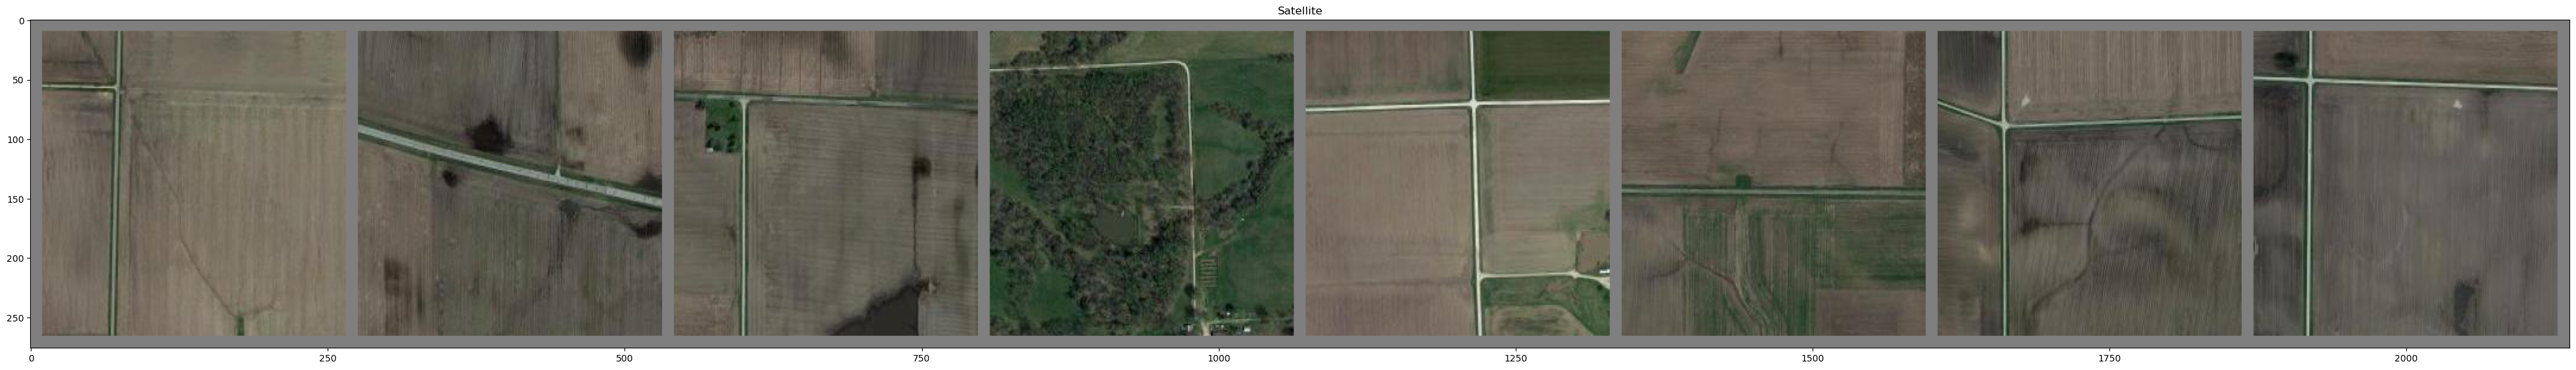

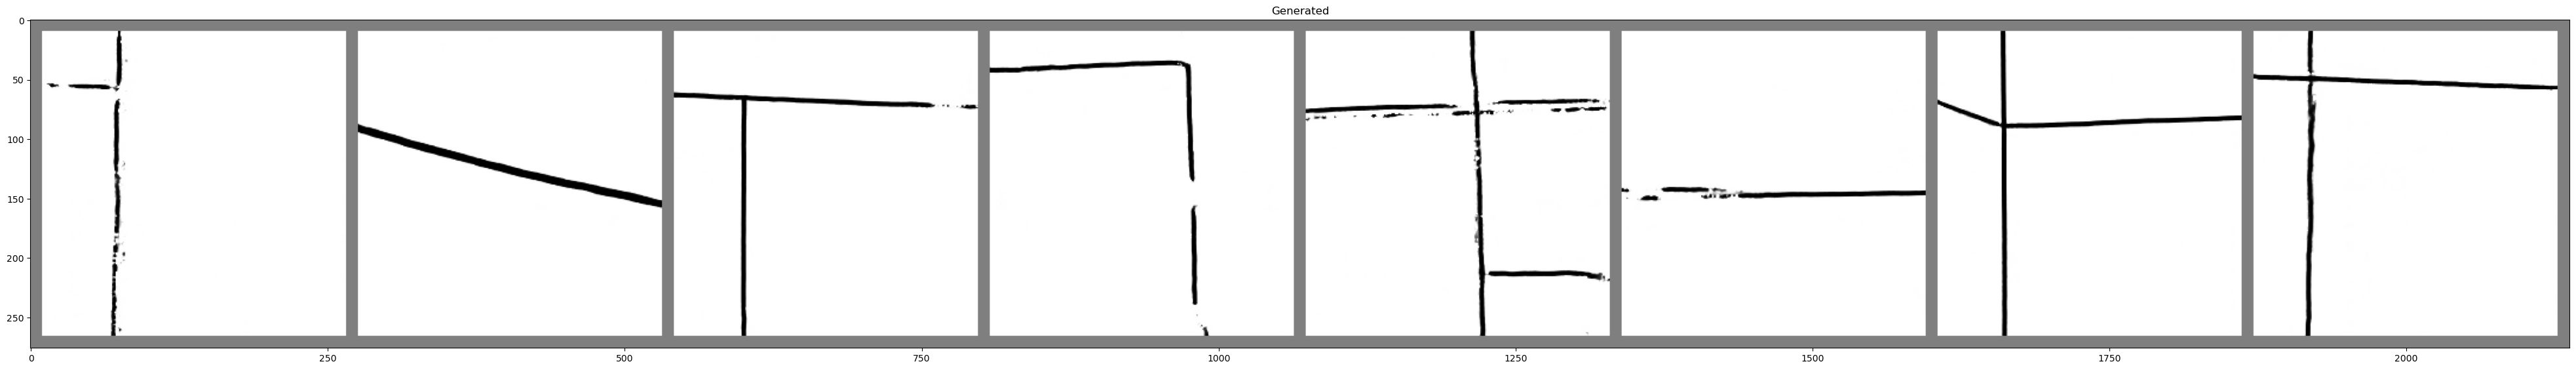

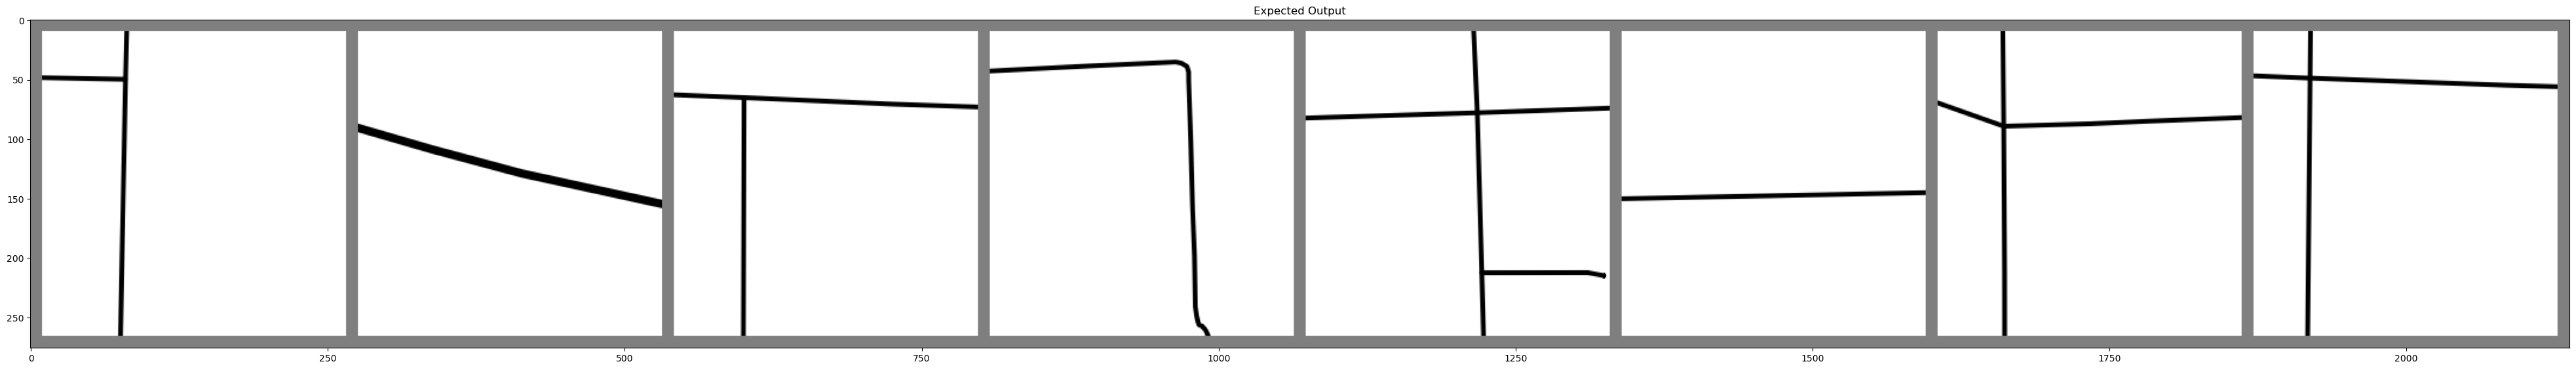

In [26]:
test_imgs,_ = next(iter(dataloader_val))

satellite = test_imgs[:,:,:,:256].to(device)
maps = test_imgs[:,:,:,256:].to(device)

gen = model_G(satellite)
#gen = gen[0]

satellite = satellite.detach().cpu()
gen = gen.detach().cpu()
maps = maps.detach().cpu()

show_image(torchvision.utils.make_grid(satellite, padding=10), title="Satellite", figsize=(50,50))
show_image(torchvision.utils.make_grid(gen, padding=10), title="Generated", figsize=(50,50))
show_image(torchvision.utils.make_grid(maps, padding=10), title="Expected Output", figsize=(50,50))